# How municipal median income affects the results of Finnish matriculation examination results

# 1. Abstract
In this study we gauge the effects of median income for a municipality on the results of the matriculation exam in different schools. We also form a model in order to predict the finnish matriculation exam results for individual schools for the autumn term 2018.

# 2. Introduction and description of data

## Income data
Income data for different municipalities was obtained from the table incomes statistics, provided by Statistics Finland. Data for all finnish municipalities was available for the years 2005 - 2016. In this report, data on the years 2014 - 2016 was used. The data was obtained from the open data set provided by Statistics Finland on ther offical website [d1].

The data consists of metrics for each municipality. For each year there is one datum per municipality. The data contains the following variables of interest:
* $\texttt{year}$
* $\texttt{municipality}$, name of the municipality
* $\texttt{Number of income recipients}$
* $\texttt{Taxable income, median}$
* $\texttt{Municipal tax, mean}$
* Additional variables were not considered

The income data was joined with data linking each municipality name to a municipality code.

## Matriculation examination data
The Finnish matriculation examination is a naition-wide standardised test for upper secondary school. Students are given questions on different topics on multiple occasions in varying subjects, such as mother tongue, mathematics, physics, biology, languages and more. The exam is held twice a year (autumn and spring).

The exam is graded on a scale of (from best to worst): laudatur (L), eximia cum laude approbatur (E), magna cum laude approbatur (M), cum laude approbatur (C), lubenter approbatur (B), approbatur (A) and improbatur (I). When calculating the numerical mean, the values are represented as numbers on a scale from 2-7 (failed exams, Improbatur, are not included in the calculation).

Data for the examination for all participating schools results was avaiable for the years 2012 - 2018 (spring). In this report, data on the years 2014 - 2016 was used. The data was obtained from the open data set provided by the Matriculation examinaton board on ther offical website [d2].

The data consists of a set of metrics for each school. For each year there is two datum per shool, one for each round. The data contains thefollowing variables of interest:
* $\texttt{round}$, examination round
* $\texttt{year}$, the year-part of the round
* $\texttt{season}$, the season part of the round (K=spring, S=autumn)
* $\texttt{school_id}$, school id number
* $\texttt{mean_ob}$, school mean of obligatory subject scores
* $\texttt{mean}$, school mean of all subjects
* $\texttt{n}$, number of students (for above metrics)
* $\texttt{mean_pkr}$, school mean of "advanced" subjects
* $\texttt{n_pkr}$, number of students (for above metric)
* Additional variables were not considered

**It is important to not that "$\texttt{mean}$" is the name of one of the variables of interest and should not be confused with the "mean" of an arbitrary variable.** 


The matriculation examination data was joined with data linking each school id to a municipality code.




In [39]:
import numpy as np
import pandas as pd
from data import Data
import config
import matplotlib.pyplot as plt
from scipy import stats

# Load income and examination result data
df_income, df_results = Data.load()
df_all = pd.merge(df_results, df_income, on=["municipality_code", "year"], how='inner')

# 3. Hypothesis

Our hypithesis was that **schools in municipalities with a higher median income will perform better in matriculation exams**, than schools in municipalities with lower median income. This is indicated by the correlation, $\rho$, between these values.

Our null hypothesis is thus
$$H_0: \mu_{\rho} = 0$$
where $\mu_{\rho}$ is the mean of the correlation coefficient between examination results for a school within a municipality, and the median income in the municipality.

# 4. Analysis of data
The joint data has 18 dimensions, and 6 of them were mainly used: $\texttt{year, season, municipality, school_id, mean}$ and "$\texttt{Taxable income, median}$".

In [2]:
df_all.head()

,round,school_id,pass,hylatty,h_tai_k,graduated,mean_ob,mean,n,mean_pkr,n_pkr,municipality_code,year,season,municipality,number of income recipients,"taxable income, mean","taxable income, median"
0,2014K,1001,35,2.0,2.0,35,3.94,3.88,5.60,3.94,4.37,233,2014,K,Kauhava,14280,25046,21070
1,2014K,1269,57,2.0,2.0,56,4.48,4.40,5.07,4.52,3.86,233,2014,K,Kauhava,14280,25046,21070
2,2014S,1001,1,1.0,1.0,1,3.25,3.17,6.00,3.20,5.00,233,2014,S,Kauhava,14280,25046,21070
3,2014S,1269,1,1.0,1.0,1,3.25,3.00,5.00,3.00,4.00,233,2014,S,Kauhava,14280,25046,21070
4,2014K,1002,63,3.0,4.0,62,4.11,4.04,5.62,4.16,4.67,5,2014,K,Alajärvi,8372,22634,18729


## 4.1 Bivariate analysis
To find out more about the relationships in the data, the correlation matrix of selected fields in the data was calculated.

In [5]:
# Univariate co-variance
df_quantitative = df_all.drop(columns=['municipality','municipality_code','round','school_id','season', 'graduated', 'hylatty', 'h_tai_k','year','n','n_pkr'])
df_centered = df_quantitative - df_quantitative.mean()
df_standard = df_centered / df_centered.std()

df_standard.cov()

,pass,mean_ob,mean,mean_pkr,number of income recipients,"taxable income, mean","taxable income, median"
pass,1.000000,0.407887,0.413399,0.404490,0.237565,0.223787,0.235225
mean_ob,0.407887,1.000000,0.989239,0.972556,0.219633,0.165333,0.126628
mean,0.413399,0.989239,1.000000,0.978917,0.221414,0.159225,0.118550
mean_pkr,0.404490,0.972556,0.978917,1.000000,0.216461,0.146029,0.106030
number of income recipients,0.237565,0.219633,0.221414,0.216461,1.000000,0.537727,0.478087
"taxable income, mean",0.223787,0.165333,0.159225,0.146029,0.537727,1.000000,0.918734
"taxable income, median",0.235225,0.126628,0.118550,0.106030,0.478087,0.918734,1.000000


The correlation matrix did not reveal any unexpected correlations in the data. Some highly-correlated values in the matrix, such as $\texttt{mean}$ and $\texttt{mean_pkr}$ can be explained by the values measuring the same underlying phenomenon.

We also plotted the scatterplot of the exam means versus income median in the school's municipality.

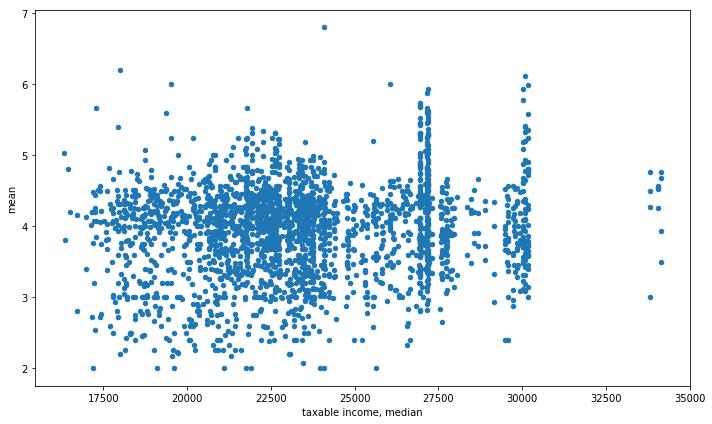

In [4]:
# Simple scatter plot of mean vs. median income
df_all.plot.scatter(x='taxable income, median',y='mean',figsize=(10,6))
plt.tight_layout()

The scatterplot shows that both the median income and the exam mean seem to be distributed unimodally. An initial correlation coefficient was calculated for the data set.

In [5]:
p = df_centered['mean'].corr(df_centered['taxable income, mean'])
print("Pearson corr. coef:",round(p, 3))

Pearson corr. coef: 0.159


The analysis without any outlier removal or data preprocessing has a correlation of $p=0.159$. No conclusions should be done based on this crude value, but it indicated the possibility of a correlation. 

## 4.2 Segmenting and outlier removal
Distinct clusters were identified based on the scatter plot.

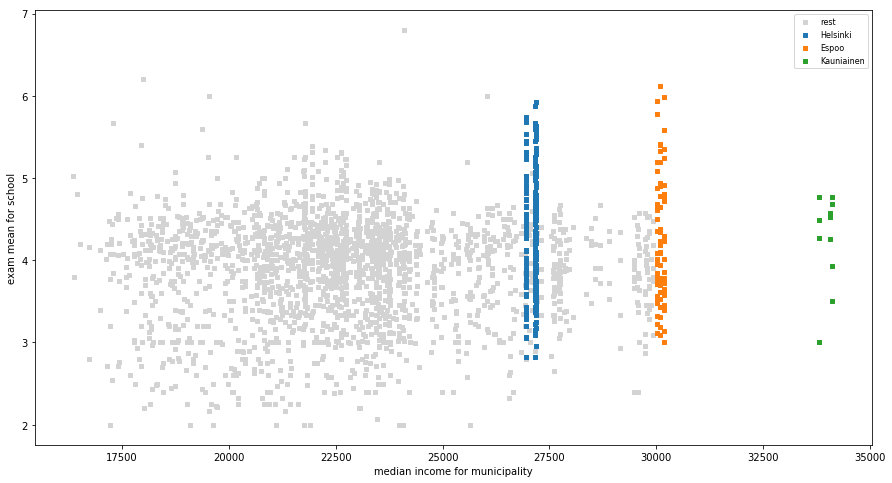

In [3]:
import helpers
helpers.plot_data(df_all, selected_classes=['Helsinki', 'Espoo', 'Kauniainen'])

The largest urban cities deviate from the rest of the country. The cities Helsinki, Espoo and Kauniainen were excluded as outliers in order to b able to treat the data as unimodal.


Further analysis on differences between rounds was performed to see the difference between spring (K) and autumn (S).

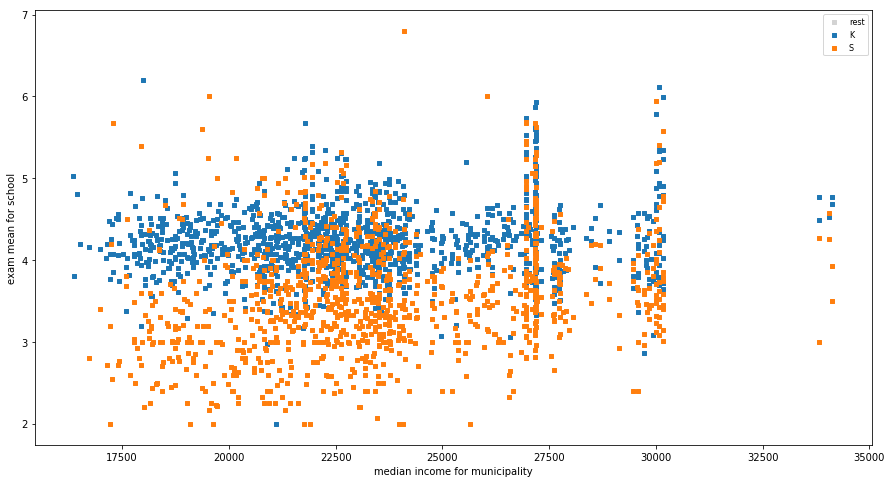

In [7]:
helpers.plot_data(df_all, selected_classes=['K','S'], class_variable='season')

In [2]:
excluded_municipalities = ['Helsinki', 'Espoo', 'Kauniainen']
df_clean_spring = df_all[
                    (~df_all['municipality'].isin(excluded_municipalities)) &
                    (df_all['season'] == 'K')]
df_clean_autumn = df_all[
                    (~df_all['municipality'].isin(excluded_municipalities)) &
                    (df_all['season'] == 'S')]

print("Autumn mean mean: ", round(df_clean_autumn.loc[:,'mean'].mean(),2))
print("Spring mean mean: ",round(df_clean_spring.loc[:,'mean'].mean(),2))
print("Autumn mean std: ", round(df_clean_autumn.loc[:,'mean'].std(),2))
print("Spring mean std: ",round(df_clean_spring.loc[:,'mean'].std(),2))

Autumn mean mean:  3.5
Spring mean mean:  4.2
Autumn mean std:  0.66
Spring mean std:  0.37


The rounds K (spring) and S (autumn) differ in their means and were treated as separate data sets.

# 5. Methods
Two models were fit for the data. First, a multinormal distribution was fit in order to assess the correlation between the variables of interest, matriculation exam scores and median income levels.
Then a hirearchical model was derived to fit to the exam score data for specific schools. We also assessed the possibility of making predictions based on the models. 

##  5.1 Multinormal Model
### Model
A linear model was deemed not to be suitable for the data, due to the variance changing as a function of median income. This can be verified from the scatter plot. Instead a multinormal distribution was fit to the data in order to find the correlation coefficient $\rho$. Based on $\rho$ the hypothesis could be tested. The mean exam results, $y$, and the median income $x$, were assumed to follow a multinormal distribution:

$$
(y,x) \sim \mathcal{N}(\mu, \Sigma)
$$
where $\Sigma$ is the population level correlation matrix
$$
\Sigma = 
\begin{bmatrix}
\sigma_{\text{income}}&\rho*\sigma_{\text{income}}*\sigma_{\text{mean}}\\
\rho*\sigma_{\text{mean}}*\sigma_{\text{income}}&\sigma_{\text{mean}}\\
\end{bmatrix}
$$

The parameter $\sigma_{\text{mean}}$ is calculated prior to the simulation and fed as a constant into the model. Based on the bi-variate analysis we sat $\sigma_{\text{mean}} = 0.5$.
### Parameters
The model estimates the population mean $\mu$, population income standard deviation $\sigma_{\text{income}}$ and the correlation coefficient $\rho$. These can be used to assess wether $y$ is dependent on $x$.
### Priors
The population distribution mean, $\mu$, was assumed to also follow a normal distribution and it was given a weakly informative prior:
$$
\mu \sim \mathcal{N}(\mu_0, \tau) 
$$
with the values
$$
\mu \sim \mathcal{N} \left (
\begin{bmatrix}
22500\\
4.5\\
\end{bmatrix}
,
\begin{bmatrix}
100^2&0\\
0&1^2\\
\end{bmatrix}
\right )$$

The prior variance of the median income within $22500 \pm 10000$, was chosen based on the bivariate data-analysis. Similarly, the exam mean was chosen to vary between the exam scale half-point $4.5 \pm 1$. The exam scale half-point is calculated as $2 + (7-2)/5$, see sec. "analysis of data" .

### Stan model
The Stan code for the multinormal model is presented below.

In [12]:
with open('model.multinormal.stan', 'r') as file:
    print(file.read())

data {
  int<lower=0> N;          // num. samples
  vector[2] y[N];          // [income', mean']
  real sigma_mean;         // exam mean std.
  vector[2] mu0;           // prior mu mean
  cov_matrix[2] tau;       // prior mu cov matrix.
}
parameters {
  real<lower=-1, upper=1> rho;
  vector[2] mu;
  real<lower=0> sigma_income;
}
transformed parameters {
  cov_matrix[2] sigma;
  sigma[1,1] = sigma_income * sigma_income;
  sigma[1,2] = sigma_income * sigma_mean * rho;
  sigma[2,1] = sigma_income * sigma_mean * rho;
  sigma[2,2] = sigma_mean * sigma_mean;
}
model {
  mu ~ multi_normal(mu0, tau);      // prior
  for (n in 1:N) {
    y[n] ~ multi_normal(mu, sigma); // posterior
  }
}
generated quantities {
  vector[N] log_lik;
  for (i in 1:N)
    log_lik[i] = multi_normal_lpdf(y[i] | mu, sigma);
}



The income median and exam mean are fed into the model via $\texttt{y}$. The model estimates $\rho, \mu$ and $\sigma_0$. Also the log posterior density was calculated for use in model validation.

## 5.2 Hierarchical model
### Model
We create a model to be able to predict the matriculation exam scores for schools in specific municipalities. As the schools in a specific municipality are run by the same entity we assume the following we use a hierarchical normal model. The assumptions for the model are the following:
- The scores are independently normally distributed for each school $j$ with means $\mu_j$ and common variance $\sigma^2$.
- The group means $\mu_j$ follow a normal distribution with mean $\theta$ and variance $\tau^2$.

Thus for a municipality with the schools $j = 1, \dots, J$ and the matriculation exam scores $y_{ij}, i=1,\dots,n_j$ from the schools the
joint posterior density looks as follows [4]:
$$
p(\mu, \theta, \log{\sigma}, \log{\tau} | y)  \propto \tau \prod_{j=1}^J \mathcal{N}(\mu_j | \theta, \tau^2)
\prod_{j=1}^J \prod_{i=1}^{n_j} \mathcal{N} (y_{ij}  | \mu_k, \sigma^2)
$$


### Parameters
The model can be fitted for a specific municipality and estimates the parameters $\theta$ and $\tau$ for the normal distribution
from which the school means $\mu_j, j=1,\dots,J$ are drawn. It also estimates the means $\mu_j$ and the shared variance $\sigma^2$ for
the schools. These parameters can be used to make predictions for the scores of the schools in upcoming matriculation exams and
to predict the scores of potential new schools in the municipality.


### Priors
TODO, currently noninformative
The population distribution mean, $\mu$, was assumed to also follow a normal distribution and it was given a weakly informative prior:
$$
\mu \sim \mathcal{N}(\mu_0, \tau) 
$$
with the values
$$
\mu \sim \mathcal{N} \left (
\begin{bmatrix}
22500\\
4.5\\
\end{bmatrix}
,
\begin{bmatrix}
100^2&0\\
0&1^2\\
\end{bmatrix}
\right )$$

The prior variance of the median income within $22500 \pm 10000$, was chosen based on the bivariate data-analysis. Similarly, the exam mean was chosen to vary between the exam scale half-point $4.5 \pm 1$. The exam scale half-point is calculated as $2 + (7-2)/5$, see sec. "analysis of data" .

### Stan model
The Stan code for the hierarchical normal model is presented below.

In [2]:
with open('model.hierarchical.stan', 'r') as file:
    print(file.read())

data {
  int<lower=0> N;           // num. samples
  int<lower=0> K;           // num. schools
  int<lower=1,upper=K> x[N];// school indicator
  vector[N] y;              // exam means
  // real sigma0;              // prior std.
  // real mu0;                 // prior mean
}
parameters {
  vector[K] mu;             // school means
  real<lower=0> sigma;      // common std?
  real omega;               // school mean mean
  real<lower=0> tau2;       // school mean variance
}
model {
  // add prior for omega?
  // omega ~ normal(sigma0, mu0);

  mu ~ normal(omega, tau2);
  y ~ normal(mu[x], sigma);
}



# 6. Experiments
The Stan models were harnessed using Python 3, and the values and a fraction of the data was fed into the models.
## 6.1 Multinormal model


In [ ]:
import model_utils
from model_utils import Model

import logging
logging.getLogger("pystan").setLevel(logging.ERROR)

# Sample
sample = df_clean_spring.sample(frac=0.1, random_state=1)

# Prepare data
N, d = sample.shape
y = sample['mean']
x = sample['taxable income, median']
xy = list(zip(x,y))
data = dict(
    N=N,
    y=xy,
    sigma_mean=0.5,
    tau=np.array([[100,0],[0,1]]),
    mu0=[22500, 4.5]
)

# Prepare stan
print("Compiling model...")
multinormal_model = Model('model.multinormal.stan')
print("Fitting data to model...")
multinormal_fit = multinormal_model.sample(data=data)
multinormal_samples = multinormal_fit.extract(permuted=True)
print("...Fitted")

In [15]:
multinormal_fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_d996924e298f2731c6436084b0c0c09c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho           -0.04  1.9e-3   0.12  -0.27  -0.13  -0.04   0.05   0.21   4184    1.0
mu[1]         2.2e4    0.15   9.99  2.2e4  2.2e4  2.2e4  2.3e4  2.3e4   4199    1.0
mu[2]          4.19  6.9e-4   0.05    4.1   4.16   4.19   4.23   4.29   4719    1.0
sigma_income 2887.2    3.08 197.63 2535.6 2747.3 2873.5 3015.0 3305.3   4105    1.0
sigma[1,1]    8.4e6   1.8e4  1.2e6  6.4e6  7.5e6  8.3e6  9.1e6  1.1e7   4018    1.0
sigma[2,1]   -54.53    2.87 182.27 -405.7 -179.1 -56.43  70.72 300.66   4028    1.0
sigma[1,2]   -54.53    2.87 182.27 -405.7 -179.1 -56.43  70.72 300.66   4028    1.0
sigma[2,2]     0.25     nan    0.0   0.25   0.25   0.25   0.25   0.25    nan    nan
log_lik[1]   -1

Note that $\texttt{sigma[1,1]}$ and $\texttt{sigma[2,2]}$ have been fed to the model as data ($\texttt{sigma0}$ and $\texttt{sigma1}$) and are not evalated by the model. Their $\hat{R}$ should be ignored.

The draws on parameters $\rho, \sigma_0^2$ and $\mu$ have the following distribution:

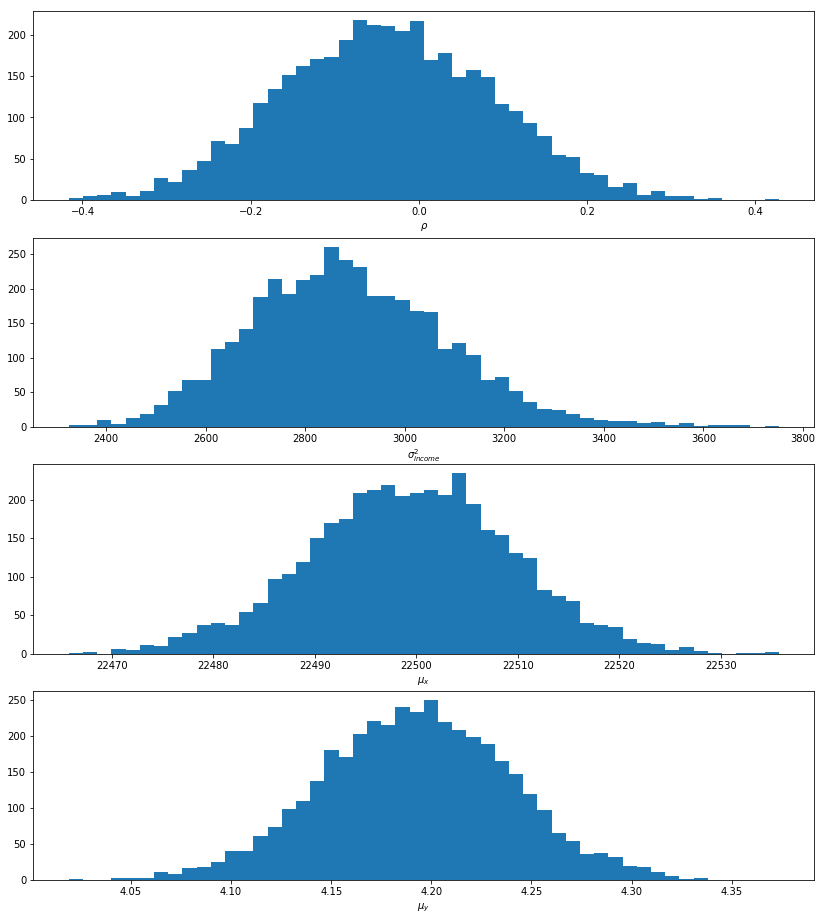

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))
samples = multinormal_samples
mu_ = samples['mu'].T

ax1.hist(samples['rho'], 50)
ax1.set_xlabel(r"$\rho$")
ax2.hist(samples['sigma_income'], 50)
ax2.set_xlabel(r"$\sigma_{income}^2$")
ax3.hist(mu_[0], 50)
ax3.set_xlabel("$\mu_x$")
ax4.hist(mu_[1], 50)
ax4.set_xlabel("$\mu_y$")
plt.show()

# 6.2 Hierarchical model
A model is fitted with the values from Helsinki for the autumn exams. A separate and pooled model is also tested but yield worse PSIS-loo values (see Section 7.2) so the hierarchical model is selected.

In [ ]:
import model_utils
from model_utils import Model
import helpers
from res2018 import load_2018

import logging
logging.getLogger("pystan").setLevel(logging.ERROR)

# Prepare data
def data_municipality(municipality):
    df = df_all[(df_all['municipality'] == municipality) & (df_all['season'] == 'S')]
    df_2018 = load_2018()
    
    number_of_schools = 0
    schools_dict = {}
    for i, val in enumerate(df['school_id'].unique()):
        number_of_schools += 1
        df.loc[(df['school_id'] == val), 'school_number'] = i+1
        df_2018.loc[(df_2018['school_id'] == val), 'school_number'] = i+1
        schools_dict[df[(df['school_id'] == val)]['school_name'].values[0]] = i+1
    df.school_number = df.school_number.astype(int)
    
    sample = df.sample(frac=1, random_state=1)
    
    # Prepare data
    N, d = sample.shape
    K = number_of_schools
    y = sample['mean'].values.flatten()
    x = sample['school_number'].values.flatten()
    
    data = dict(
        N=N,
        K=K,
        x=x,
        y=y,
    )
    
    return data, schools_dict, df_2018
    

data, schools_dict, df_2018 = data_municipality('Helsinki')

In [119]:
print("Compiling hierarchical model...")
hierarchical_model = Model('model.hierarchical.stan')
print("Fitting data to hierarchical model...")
hierarchical_fit = hierarchical_model.sample(data=data)
hierarchical_samples = hierarchical_fit.extract(permuted=True)
print("...Fitted")

Compiling hierarchical model...
Using cached StanModel
Fitting data to hierarchical model...
...Fitted


In [118]:
print("Compiling separate model...")
separate_model = Model('model.separate.stan')
print("Fitting data to hierarchical model...")
separate_fit = separate_model.sample(data=data)
separate_samples = separate_fit.extract(permuted=True)
print("...Fitted")

Compiling separate model...
Using cached StanModel
Fitting data to hierarchical model...
...Fitted


In [6]:
print("Compiling pooled model...")
pooled_model = Model('model.pooled.stan')
print("Fitting data to pooled model...")
pooled_fit = pooled_model.sample(data=data)
pooled_samples = pooled_fit.extract(permuted=True)
print("...Fitted")

Compiling pooled model...
Using cached StanModel
Fitting data to pooled model...
...Fitted


The draws on parameters $\theta, \sigma_0^2$ and $\tau^2$ as well as $\mu$ for the school *Helsingin normaalilyseo* have the following distributions:

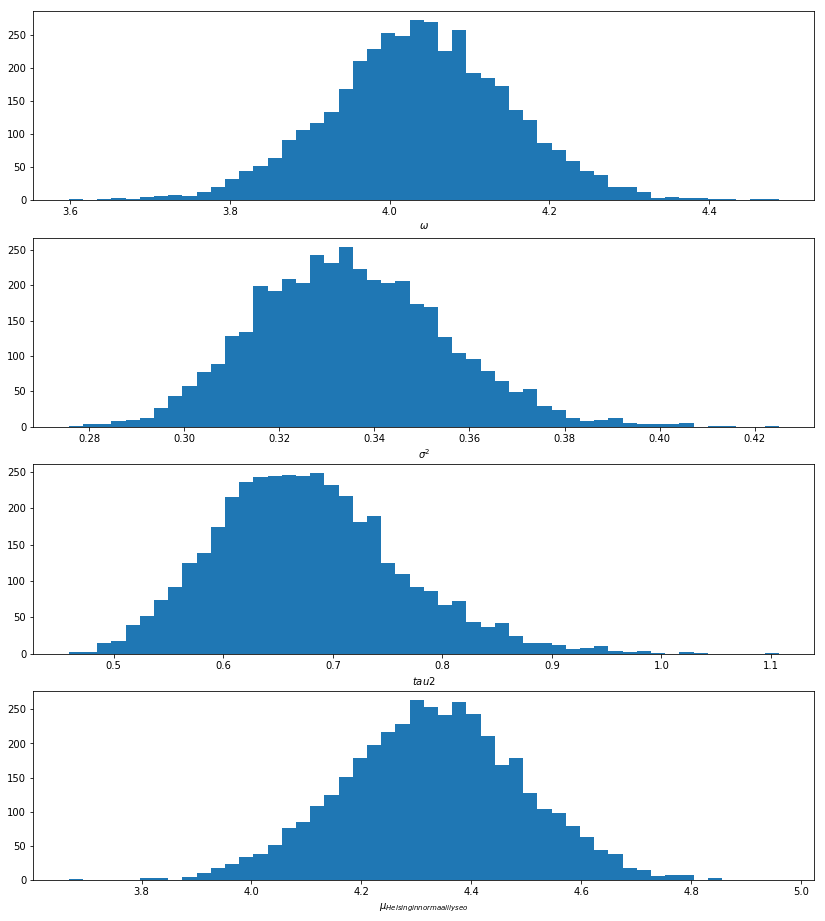

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))
mu_schools = hierarchical_samples['mu'].T

ax1.hist(hierarchical_samples['omega'], 50)
ax1.set_xlabel(r"$\omega$")
ax2.hist(hierarchical_samples['sigma'], 50)
ax2.set_xlabel(r"$\sigma^2$")
ax3.hist(hierarchical_samples['tau2'], 50)
ax3.set_xlabel("$tau2$")
ax4.hist(mu_schools[schools_dict['Helsingin normaalilyseo']], 50)
ax4.set_xlabel("$\mu_{Helsingin normaalilyseo}$")
plt.show()

# 7 Model validation

Both models converge, as indicated by the $\hat{R}$ values of 1.0. [4].

The models were validating using Pareto-smoothed importance sampling and leave-one-out cross validation (PSIS-loo) as described in [3].

# 7.1 Multinormal Model

The log-predictive densities were fed into PSIS-loo reference functions by Vehtari [5] in order to validate the models.

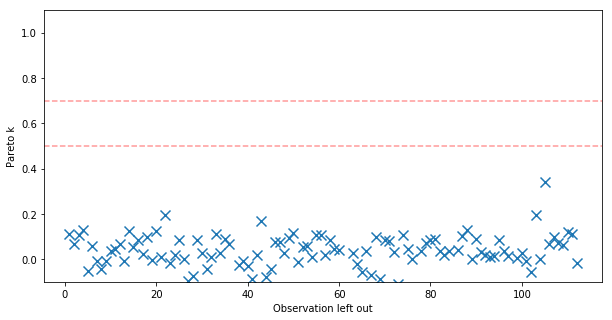

In [172]:
import psis
loo, loos, ks  = psis.psisloo(multinormal_fit.extract(permuted=True)['log_lik'])
helpers.plot_pareto_ks2(ks)

The resulting Pareto shape parameters, or $k$-values describes the leave-one-out cross validation scores of the model. The $k$-values can be used to assess the reliability of the estimated parameters. $K$-values below 0.5 are considered good, and values below 0.7 are considered acceptable. 

The values are shown in the above figure and they indicate that the model fits the data robustly and the samples drawn using it are reliable. [3]




# 7.2 Hierarchical model
The PSIS-loo values are calculated for the hierarchical, separate and pooled models for predicting matriculation exam scores. The $k$-values are plotted below.

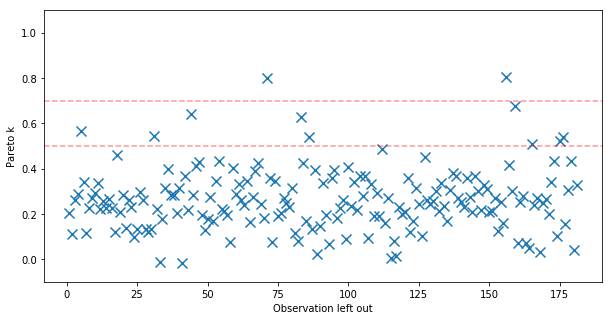

In [12]:
loo_hier, loos, ks  = psis.psisloo(hierarchical_fit.extract(permuted=True)['log_lik'])
helpers.plot_pareto_ks2(ks)

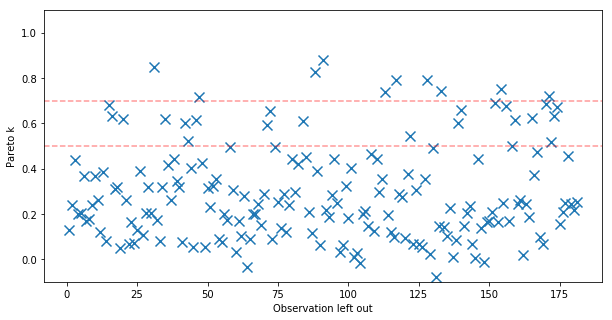

In [18]:
loo_separate, loos, ks  = psis.psisloo(separate_fit.extract(permuted=True)['log_lik'])
helpers.plot_pareto_ks2(ks)

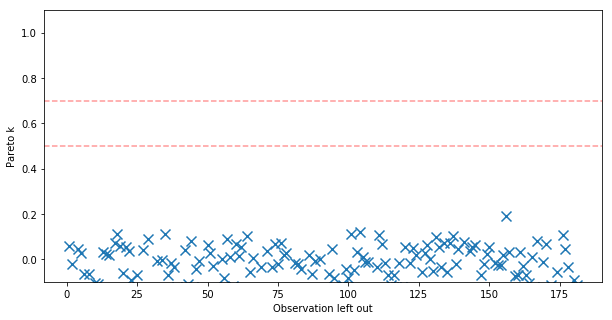

In [15]:
loo_pooled, loos, ks  = psis.psisloo(pooled_fit.extract(permuted=True)['log_lik'])
helpers.plot_pareto_ks2(ks)

In [16]:
print("Hierarchical PSIS-loo: {}".format(loo_hier))
print("Separate PSIS-loo: {}".format(loo_separate))
print("Pooled PSIS-loo: {}".format(loo_pooled))

Hierarchical PSIS-loo: -80.00020150332898
Separate PSIS-loo: -791.9629948543729
Pooled PSIS-loo: -198.64762480320923


As mentioned in Section 7.1 the $k$-values can be used to assess the reliability of PSIS-loo estimates.

$k$-values below $0.5$ are considered good, and values below $0.7$ are considered acceptable. The $k$-values for the hierarchical mostly below $0.7$ and thus the PSIS-loo estimate can be considered accurate.
The separate model has worse $k$-values but the clear majority is still below $0.7$.  We could manually calculate the LOO values (leave observation out and refit model etc.) for the observations with bad $k$-values but as the PSIS-loo value for the separate model is clearly worse than the other two we will simply discard the model.
All $k$-values for the pooled model are clearly below $0.7$.

We choose the model that has the highest PSIS-LOO value, **the hierarchical model**. The PSIS-LOO
value is an estimate for out-of-sample predictive fit.

# 8 Hypothesis testing

The multinormal model indicates that $\mu_{\rho} = 0.04$ with $\sigma_{\rho} = 0.0019$. According to our null-hypothesis, presented previously, $H_0: \mu_{\rho} = 0$.

We can test the hypothesis with a two-tailed with a confidence level $\alpha = 95\%$ [1].

$$
\text{reject} \quad H_0 \quad \text{if} \quad p(Z) < \alpha \iff p \left ( \frac{\mu_{\rho} - 0}{\sigma_{\rho} \sqrt{N}} \right ) < \alpha
$$

In [14]:
from scipy.stats import norm
samples = multinormal_samples
rho_mean = samples['rho'].mean()
rho_sd = samples['rho'].std()
a = 0.05
z = (rho_mean - 0) / ( rho_sd * np.sqrt(N) )
p = norm.cdf(z)
p < a

False

Based on this, we cannot reject $H_0$. There does not seem to be correlation between the $\texttt{mean}$ and $\texttt{Taxable income, median}$.

# 9 Results and discussion

## Results of the Multinormal model
The multinormal model fit the data well based on the model validation crieria. Using the model the distribution of the correlation, $\rho$, was estimated. By performing hypothesis testing, the value of $\rho$ indicates that **there is no correlation between the $\texttt{mean}$ and $\texttt{Taxable income, median}$**.

This could indicate that the wealth of the municipality does not affect matrticulation examination grades. However, based on this report, we can not say whether individual family income affects the examination results. The results indicate that the examination results are at least not directly tied to income. This should be positive news for the equality of students.

## Results of the hierarchical model

As it is not possible to predict exam scores based on municipal income, we implemented a hierarchical model, which is able to predict the results of upcoming matriculation exams. The model is presented in Section 6.2 and 7.2. We compare the predictions of the model to the actual results for the most recent matriculation exam, fall 2018 for various schools in Helsinki.

In [76]:
school_means = {}
means = hierarchical_fit.summary()['summary'][:len(schools_dict), 0]
var = hierarchical_fit.summary()['summary'][len(schools_dict), 0]

for school, school_id in schools_dict.items():
    school_means[school_id] = means[school_id-1]

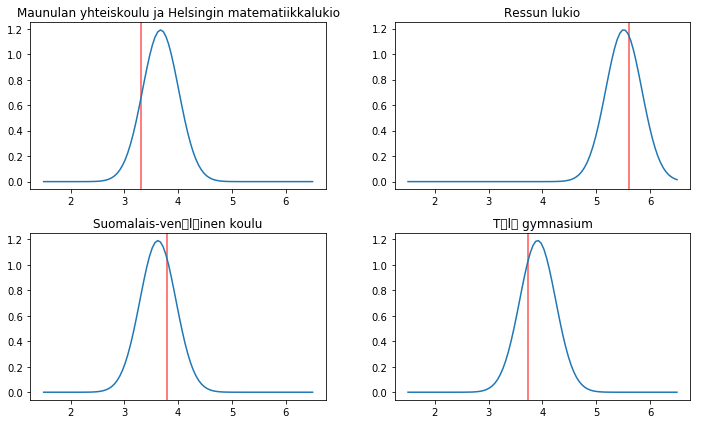

In [116]:
import random
test_schools = random.sample(list(school_means.items()), 4)

def school_info(school_number):
    return (
        df_res_2018[df_res_2018['school_number'] == school_number]['mean'].values[0],
        df_res_2018[df_res_2018['school_number'] == school_number]['school_name'].values[0]
    )
    
fig, axes = plt.subplots(2, 2, figsize=(10,6))
x = np.linspace(1.5, 6.5, 100)
for i, (school_number, mean) in enumerate(test_schools):
    mean_2018, school_name = school_info(school_number)
    axes[i%2][i//2].plot(x, stats.norm.pdf(x, loc=mean, scale=var))
    axes[i%2][i//2].axvline(x=mean_2018, linewidth=2, color='r', alpha=0.5, zorder=1)
    axes[i%2][i//2].set_title(school_name)

plt.tight_layout()
plt.show()

## Evaluation of methods and Future improvements

We must note that in the study the largst urban cities, Helsinki, Espoo and Kauniainen were left out as outliers in the multinormal model. Understanding the relationship in these cities requires further study.

Futhermore, the number of income recipients and peopl attending the exam was available in the data set, but were not used. Future evaluation should be performed on wether $t$-distributions using this data could improve the models. For example the hierarchical model could use $t$-distributions for each school exam mean and the municipal level could utilize the number of income recipients in a $t$-distribution.

Regarding the data used, the income and exam data sets overlap also in th period 2012-2013, this data could be easily incorporated to yield more accurate models.

# References

[1] Multivariate Analysis (1979, 2003 reprint)  
Mardia, K.V., Kent, J.T., Bibby, J.M. Academic Press, ISBN 0-12-471252-5 Pbk

[2] "Ylioppilastutkinnon pisteitys", Grading of the matriculation examination (2018)  
Opintopolku.fi, web portal by the Finnish National Agency for Education (EDUFI) (cited on 5.12.2018)  
https://opintopolku.fi/wp/yliopisto/kuka-voi-hakea-yliopistoon/ylioppilastutkinnon-pisteitys-2/

[3] "Practical Bayesian model evaluation using leave-one-out cross- validation and WAIC. Statistics and Computing" (2017)  
Statistics and Computing (2017) 27: 1413  
https://doi.org/10.1007/s11222-016-9696-4

[4] "Bayesian data analysis", 2nd edition (2004)  
Gelman, Carlin, Stern, Rubin, Chapman & Hall/CRC

[5] "Pareto smoothed importance sampling (PSIS) and PSIS leave-one-out cross-validation reference code" (2017)  
Vehtari, A. https://github.com/avehtari/PSIS.

# Data sources
[d1] Data on taxablew income in Finland  
     http://www.stat.fi/meta/til/tvt_en.html

[d2] Matriculation exam metrics for the schools in Finland  
     https://www.ylioppilastutkinto.fi/tietopalvelut/tilastot/koulukohtaisia-tunnuslukuja
     
